In [1]:
import numpy as np
import json
from sklearn.metrics import f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt

In [2]:
class Linear_BN_leakyReLU(nn.Module):
    """
    A nn.Module that consists of a Linear layer followed by BatchNorm1d and a leaky ReLu activation
    """

    def __init__(self, in_features, out_features, bias=False, eps=1e-04):
        super(Linear_BN_leakyReLU, self).__init__()

        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.bn = nn.BatchNorm1d(out_features, eps=eps, affine=bias)

    def forward(self, x):
        return F.leaky_relu(self.bn(self.linear(x)))

In [3]:
class MLP(nn.Module):
    
    def __init__(self, x_dim, h_dims=[128, 64], rep_dim=32, bias=False):
        super(MLP, self).__init__()

        self.rep_dim = rep_dim # representation dimensionality, i.e, dim of the code layer or last layer.

        neurons = [x_dim, *h_dims]
        layers = [Linear_BN_leakyReLU(neurons[i - 1], neurons[i], bias=bias) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(layers)
        self.code = nn.Linear(h_dims[-1], rep_dim, bias=bias)

    def forward(self, x):
        x = x.view(int(x.size(0)), -1)
        for layer in self.hidden:
            x = layer(x)
        return self.code(x)


class MLP_Decoder(nn.Module):

    def __init__(self, x_dim, h_dims=[64, 128], rep_dim=32, bias=False):
        super(MLP_Decoder, self).__init__()

        self.rep_dim = rep_dim

        neurons = [rep_dim, *h_dims]
        layers = [Linear_BN_leakyReLU(neurons[i - 1], neurons[i], bias=bias) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(layers)
        self.reconstruction = nn.Linear(h_dims[-1], x_dim, bias=bias)
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = x.view(int(x.size(0)), -1)
        for layer in self.hidden:
            x = layer(x)
        x = self.reconstruction(x)
        return self.output_activation(x)


class MLP_AE(nn.Module):

    def __init__(self, x_dim, h_dims=[128, 64], rep_dim=32, bias=False):
        super(MLP_AE, self).__init__()

        self.rep_dim = rep_dim
        self.encoder = MLP(x_dim, h_dims, rep_dim, bias)
        self.decoder = MLP_Decoder(x_dim, list(reversed(h_dims)), rep_dim, bias)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
def build_network(net_name, ae_net=None):
    """Builds the neural network."""

    implemented_networks = ('arrhythmia_mlp', 'cardio_mlp', 'satellite_mlp', 'satimage-2_mlp', 'shuttle_mlp',
                            'thyroid_mlp')
    assert net_name in implemented_networks

    net = None

    if net_name == 'arrhythmia_mlp':
        net = MLP(x_dim=274, h_dims=[128, 64], rep_dim=32, bias=False)
        
    if net_name == 'thyroid_mlp':
        net = MLP(x_dim=6, h_dims=[32, 16], rep_dim=4, bias=False)

    # if net_name == 'cardio_mlp':
    #     net = MLP(x_dim=21, h_dims=[32, 16], rep_dim=8, bias=False)
    # if net_name == 'satellite_mlp':
    #     net = MLP(x_dim=36, h_dims=[32, 16], rep_dim=8, bias=False)
    # if net_name == 'satimage-2_mlp':
    #     net = MLP(x_dim=36, h_dims=[32, 16], rep_dim=8, bias=False)
    # if net_name == 'shuttle_mlp':
    #     net = MLP(x_dim=9, h_dims=[32, 16], rep_dim=8, bias=False)

    return net


def build_autoencoder(net_name):
    """Builds the corresponding autoencoder network."""

    implemented_networks = ('arrhythmia_mlp', 'cardio_mlp', 'satellite_mlp', 'satimage-2_mlp', 'shuttle_mlp',
                            'thyroid_mlp')

    assert net_name in implemented_networks

    ae_net = None

    if net_name == 'arrhythmia_mlp':
        ae_net = MLP_AE(x_dim=274, h_dims=[128, 64], rep_dim=32, bias=False)
        
    if net_name == 'thyroid_mlp':
        ae_net = MLP_AE(x_dim=6, h_dims=[32, 16], rep_dim=4, bias=False)

    # if net_name == 'cardio_mlp':
    #     ae_net = MLP_AE(x_dim=21, h_dims=[32, 16], rep_dim=8, bias=False)
    # if net_name == 'satellite_mlp':
    #     ae_net = MLP_AE(x_dim=36, h_dims=[32, 16], rep_dim=8, bias=False)
    # if net_name == 'satimage-2_mlp':
    #     ae_net = MLP_AE(x_dim=36, h_dims=[32, 16], rep_dim=8, bias=False)
    # if net_name == 'shuttle_mlp':
    #     ae_net = MLP_AE(x_dim=9, h_dims=[32, 16], rep_dim=8, bias=False)

    return ae_net

In [5]:
from dsvdd_trainer import AETrainer, DeepSVDDTrainer

In [6]:
class DeepSVDD(object):
    """A class for the Deep SVDD method.
    Attributes:
        objective: A string specifying the Deep SVDD objective (either 'one-class' or 'soft-boundary').
        nu: Deep SVDD hyperparameter nu (must be 0 < nu <= 1).
        R: Hypersphere radius R.
        c: Hypersphere center c.
        net_name: A string indicating the name of the neural network to use.
        net: The neural network \phi.
        ae_net: The autoencoder network corresponding to \phi for network weights pretraining.
        trainer: DeepSVDDTrainer to train a Deep SVDD model.
        optimizer_name: A string indicating the optimizer to use for training the Deep SVDD network.
        ae_trainer: AETrainer to train an autoencoder in pretraining.
        ae_optimizer_name: A string indicating the optimizer to use for pretraining the autoencoder.
        results: A dictionary to save the results.
    """

    def __init__(self, objective = 'one-class', nu = 0.1):
        """Inits DeepSVDD with one of the two objectives and hyperparameter nu."""

        assert objective in ('one-class', 'soft-boundary'), "Objective must be either 'one-class' or 'soft-boundary'."
        self.objective = objective
        assert (0 < nu) & (nu <= 1), "For hyperparameter nu, it must hold: 0 < nu <= 1."
        self.nu = nu
        self.R = 0.0  # hypersphere radius R
        self.c = None  # hypersphere center c

        self.net_name = None
        self.net = None  # neural network \phi

        self.trainer = None
        self.optimizer_name = None

        self.ae_net = None  # autoencoder network for pretraining
        self.ae_trainer = None
        self.ae_optimizer_name = None

        self.results = {
            'train_time': None,
            'test_auc': None,
            'test_time': None,
            'test_scores': None,
        }

    def set_network(self, net_name):
        """Builds the neural network \phi."""
        self.net_name = net_name
        self.net = build_network(net_name)

    def train(self, data_loader, optimizer_name = 'adam', lr = 0.001, n_epochs = 50,
              lr_milestones = (), batch_size = 128, weight_decay = 1e-6, device = 'cuda',
              n_jobs_dataloader = 0):
        """Trains the Deep SVDD model on the training data."""

        self.optimizer_name = optimizer_name
        self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu, optimizer_name, lr=lr,
                                       n_epochs=n_epochs, lr_milestones=lr_milestones, batch_size=batch_size,
                                       weight_decay=weight_decay, device=device, n_jobs_dataloader=n_jobs_dataloader)
        # Get the model
        self.net, self.loss_plot = self.trainer.train(data_loader, self.net)
        self.R = float(self.trainer.R.cpu().data.numpy())  # get float
        self.c = self.trainer.c.cpu().data.numpy().tolist()  # get list
        self.results['train_time'] = self.trainer.train_time

    def test(self, data_loader, device = 'cuda', n_jobs_dataloader = 0):
        """Tests the Deep SVDD model on the test data."""

        if self.trainer is None:
            self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu,
                                           device=device, n_jobs_dataloader=n_jobs_dataloader)

        self.trainer.test(data_loader, self.net)
        # Get results
        self.results['test_auc'] = self.trainer.test_auc
        self.results['test_time'] = self.trainer.test_time
        self.results['test_scores'] = self.trainer.test_scores

    def pretrain(self, train_loader, test_loader, optimizer_name = 'adam', lr = 0.001, n_epochs = 100,
                 lr_milestones = (), batch_size = 128, weight_decay = 1e-6, device = 'cuda',
                 n_jobs_dataloader = 0):
        """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

        self.ae_net = build_autoencoder(self.net_name)
        self.ae_optimizer_name = optimizer_name
        self.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                    batch_size=batch_size, weight_decay=weight_decay, device=device,
                                    n_jobs_dataloader=n_jobs_dataloader)
        self.ae_net, self.ae_loss_plot = self.ae_trainer.train(train_loader, self.ae_net)
        self.ae_trainer.test(test_loader, self.ae_net)
        self.init_network_weights_from_pretraining()

    def init_network_weights_from_pretraining(self):
        """Initialize the Deep SVDD network weights from the encoder weights of the pretraining autoencoder."""

        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict()

        # Filter out decoder network keys
        ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in net_dict}
        # Overwrite values in the existing state_dict
        net_dict.update(ae_net_dict)
        # Load the new state_dict
        self.net.load_state_dict(net_dict)

    def save_model(self, export_model, save_ae=True):
        """Save Deep SVDD model to export_model."""

        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict() if save_ae else None

        torch.save({'R': self.R,
                    'c': self.c,
                    'net_dict': net_dict,
                    'ae_net_dict': ae_net_dict}, export_model)

    def load_model(self, model_path, load_ae=False):
        """Load Deep SVDD model from model_path."""

        model_dict = torch.load(model_path)

        self.R = model_dict['R']
        self.c = model_dict['c']
        self.net.load_state_dict(model_dict['net_dict'])
        if load_ae:
            if self.ae_net is None:
                self.ae_net = build_autoencoder(self.net_name)
            self.ae_net.load_state_dict(model_dict['ae_net_dict'])

    def save_results(self, export_json):
        """Save results dict to a JSON-file."""
        with open(export_json, 'w') as fp:
            json.dump(self.results, fp)

In [7]:
sys.path.append('..')
import datasets.load_tabular as NAD

In [180]:
config = {
    "objective": 'one-class',
    "nu": 0.01,
    "net_name": 'arrhythmia_mlp',
    "ae_optimizer_name": 'adam',
    "ae_lr": 0.01,
    "ae_n_epochs": 500,
    "ae_lr_milestones": [50, 250, 500],
    "ae_batch_size": 50,
    "ae_weight_decay": 1e-4,
    "optimizer_name": 'adam',
    "lr": 0.01,
    "n_epochs": 500,
    "lr_milestones": [50, 250, 500],
    "batch_size": 50,
    "weight_decay": 1e-5,
    "n_jobs_dataloader": 0,
    "export_path": '/home/sewon/anomaly_detection/DSVDD',
    "pretrain": True,
    "num_threads": 0    
}

In [181]:
 # Default device to 'cpu' if cuda is not available
if not torch.cuda.is_available():
    device = 'cpu'
else:
    device = 'cuda'
# Set the number of threads used for parallelizing CPU operations
num_threads = config['num_threads']
if num_threads > 0:
    torch.set_num_threads(num_threads)

In [182]:
# Initialize DeepSVDD model and set neural network phi
deepSVDD = DeepSVDD(config['objective'], config['nu'])
deepSVDD.set_network(config['net_name'])

In [183]:
arrhy_train_X, arrhy_train_y, arrhy_test_X, arrhy_test_y = NAD.Arrhythmia_train_test_split('/home/sewon/anomaly_detection/datasets/')
train_data = TensorDataset(torch.FloatTensor(arrhy_train_X), torch.FloatTensor(arrhy_train_y))
train_loader = DataLoader(dataset = train_data, batch_size=config['batch_size'], shuffle=True)
test_data = TensorDataset(torch.FloatTensor(arrhy_test_X), torch.FloatTensor(arrhy_test_y))
test_loader = DataLoader(dataset = test_data, batch_size=config['batch_size'], shuffle=False)

In [184]:
if config["pretrain"]:
    # Pretrain model on dataset (via autoencoder)
    deepSVDD.pretrain(train_loader = train_loader, test_loader = test_loader,
                     optimizer_name=config['ae_optimizer_name'],
                     lr=config['ae_lr'],
                     n_epochs=config['ae_n_epochs'],
                     lr_milestones=config['ae_lr_milestones'],
                     batch_size=config['ae_batch_size'],
                     weight_decay=config['ae_weight_decay'],
                     device=device,
                     n_jobs_dataloader=config['n_jobs_dataloader'])
    

Starting pretraining...


/home/sewon/anaconda3/envs/venvs/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:418: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  LR scheduler: new learning rate is 0.0001
  LR scheduler: new learning rate is 1e-05
Pretraining Time: 4.865s
Finished pretraining.
Testing autoencoder...
Test Loss: 1264.203573
Test AUC: 55.86%
Test Time: 0.005s
Finished testing autoencoder.


In [185]:
def plot_loss_moment(losses):
    _, ax = plt.subplots(figsize=(8, 3), dpi=80)
    ax.plot(losses, 'blue', label='train', linewidth=1)
    ax.set_title('Loss change in training')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iteration')
    ax.legend(loc='upper right')
    # plt.savefig(os.path.join(config['img_dir'], 'loss_dagmm.png'))

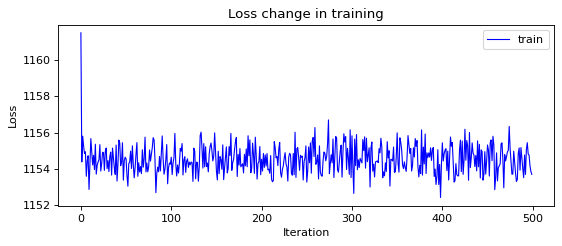

In [186]:
plot_loss_moment(deepSVDD.ae_loss_plot)

In [187]:
deepSVDD.train(train_loader,
              optimizer_name=config['optimizer_name'],
              lr=config['lr'],
              n_epochs=config['n_epochs'],
              lr_milestones=config['lr_milestones'],
              batch_size=config['batch_size'],
              weight_decay=config['weight_decay'],
              device=device,
              n_jobs_dataloader=config['n_jobs_dataloader'])


Initializing center c...
Center c initialized.
Starting training...
| Epoch: 001/500 | Train Time: 0.010s | Train Loss: 228.798965 |
| Epoch: 002/500 | Train Time: 0.009s | Train Loss: 121.443125 |
| Epoch: 003/500 | Train Time: 0.009s | Train Loss: 59.336270 |
| Epoch: 004/500 | Train Time: 0.009s | Train Loss: 30.252886 |
| Epoch: 005/500 | Train Time: 0.008s | Train Loss: 17.232923 |
| Epoch: 006/500 | Train Time: 0.008s | Train Loss: 10.458542 |
| Epoch: 007/500 | Train Time: 0.007s | Train Loss: 6.777828 |
| Epoch: 008/500 | Train Time: 0.006s | Train Loss: 4.531614 |
| Epoch: 009/500 | Train Time: 0.006s | Train Loss: 3.564690 |
| Epoch: 010/500 | Train Time: 0.006s | Train Loss: 3.173565 |
| Epoch: 011/500 | Train Time: 0.006s | Train Loss: 2.378714 |
| Epoch: 012/500 | Train Time: 0.006s | Train Loss: 2.391538 |
| Epoch: 013/500 | Train Time: 0.006s | Train Loss: 1.921255 |
| Epoch: 014/500 | Train Time: 0.006s | Train Loss: 1.407686 |
| Epoch: 015/500 | Train Time: 0.006s | Tr

/home/sewon/anaconda3/envs/venvs/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:418: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| Epoch: 070/500 | Train Time: 0.006s | Train Loss: 0.271526 |
| Epoch: 071/500 | Train Time: 0.006s | Train Loss: 0.287517 |
| Epoch: 072/500 | Train Time: 0.005s | Train Loss: 0.484717 |
| Epoch: 073/500 | Train Time: 0.005s | Train Loss: 0.326662 |
| Epoch: 074/500 | Train Time: 0.005s | Train Loss: 0.338604 |
| Epoch: 075/500 | Train Time: 0.005s | Train Loss: 0.218344 |
| Epoch: 076/500 | Train Time: 0.005s | Train Loss: 0.397823 |
| Epoch: 077/500 | Train Time: 0.005s | Train Loss: 0.329546 |
| Epoch: 078/500 | Train Time: 0.005s | Train Loss: 0.433395 |
| Epoch: 079/500 | Train Time: 0.005s | Train Loss: 0.334496 |
| Epoch: 080/500 | Train Time: 0.005s | Train Loss: 0.348299 |
| Epoch: 081/500 | Train Time: 0.005s | Train Loss: 0.275139 |
| Epoch: 082/500 | Train Time: 0.006s | Train Loss: 0.314288 |
| Epoch: 083/500 | Train Time: 0.005s | Train Loss: 0.242156 |
| Epoch: 084/500 | Train Time: 0.005s | Train Loss: 0.532947 |
| Epoch: 085/500 | Train Time: 0.005s | Train Loss: 0.2

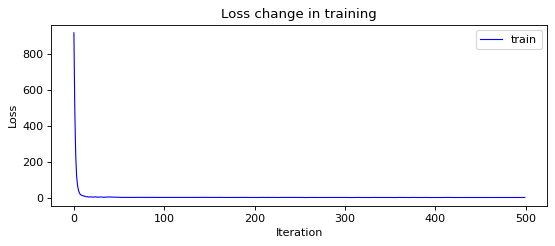

In [188]:
plot_loss_moment(deepSVDD.loss_plot)

In [189]:
# Test model
deepSVDD.test(test_loader, device=device, n_jobs_dataloader=config['n_jobs_dataloader'])

Starting testing...
Test AUC: 67.96%
Test Time: 0.005s
Finished testing.


In [190]:
# Save results, model, and configuration
deepSVDD.save_results(export_json= config["export_path"] + '/results.json')
deepSVDD.save_model(export_model=config["export_path"] + '/model.tar', save_ae = True)

In [191]:
labels, scores = zip(*deepSVDD.results['test_scores'])
labels, scores = np.array(labels), np.array(scores)

In [192]:
import pandas as pd

result_df = pd.DataFrame()
result_df['labels'] = labels
result_df['scores'] = scores

label_normal = [0]
label_abnormal = [1]

df_normal = result_df[result_df.labels == 0]
df_abnormal = result_df[result_df.labels == 1]

In [199]:
cut_90 = df_normal.scores.quantile(0.90)
y_90 = [1 if e > cut_90 else 0 for e in df_abnormal['scores'].values]

cut_85 = df_normal.scores.quantile(0.85)
y_85 = [1 if e > cut_85 else 0 for e in df_abnormal['scores'].values]

cut_80 = df_normal.scores.quantile(0.80)
y_80 = [1 if e > cut_80 else 0 for e in df_abnormal['scores'].values]

In [200]:
print("Binary F1 Score:", f1_score(y_90, np.ones_like(y_90), average = 'binary'))
print("Binary F1 Score:", f1_score(y_85, np.ones_like(y_85), average = 'binary'))
print("Binary F1 Score:", f1_score(y_80, np.ones_like(y_80), average = 'binary'))

Binary F1 Score: 0.42857142857142855
Binary F1 Score: 0.5806451612903226
Binary F1 Score: 0.625
